<a href="https://colab.research.google.com/github/marianar97/cbt-helper-api/blob/master/CactusDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Download nltk stopwords if not already downloaded
nltk.download('stopwords', quiet=True)
# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
csv_file="extracted_data.csv"
# Read the CSV file
print(f"Reading data from {csv_file}...")
df = pd.read_csv(csv_file)

# Drop rows without ground truth CBT
original_count = len(df)
df = df.dropna(subset=['ground_truth_CBT'])
filtered_count = len(df)
print(f"Dropped {original_count - filtered_count} rows without ground truth CBT.")
print(f"Analyzing {filtered_count} records.")

# Analyze intake form length
df['intake_length'] = df['intake_form'].str.len()

Reading data from extracted_data.csv...
Dropped 30 rows without ground truth CBT.
Analyzing 420 records.



=== Intake Form Length Analysis ===
Mean length: 1769.91 characters
Median length: 1762.00 characters
Min length: 1465 characters
Max length: 2170 characters


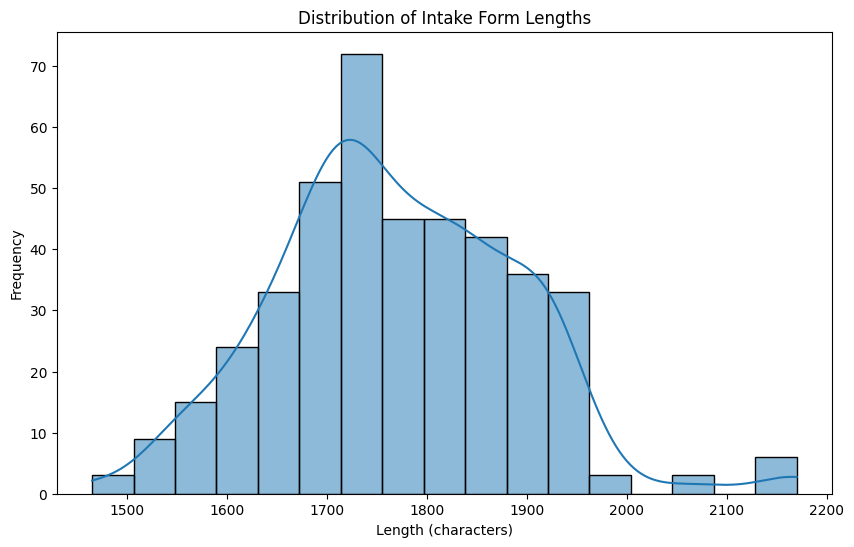

In [ ]:
print("\n=== Intake Form Length Analysis ===")
print(f"Mean length: {df['intake_length'].mean():.2f} characters")
print(f"Median length: {df['intake_length'].median():.2f} characters")
print(f"Min length: {df['intake_length'].min()} characters")
print(f"Max length: {df['intake_length'].max()} characters")

# Plot intake form length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['intake_length'], kde=True)
plt.title('Distribution of Intake Form Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()


=== Ground Truth CBT Frequency Analysis ===
Alternative Perspective: 162 (25.35%)
Evidence-Based Questioning: 135 (21.13%)
Problem-Solving Skills Training: 96 (15.02%)
Decatastrophizing: 60 (9.39%)
Pie Chart Technique: 42 (6.57%)
Efficiency Evaluation: 42 (6.57%)
Continuum Technique: 39 (6.10%)
Behavior Experiment: 21 (3.29%)
Changing Rules to Wishes: 12 (1.88%)
Pros and Cons Analysis: 9 (1.41%)
Reality Testing: 9 (1.41%)
Systematic Exposure: 6 (0.94%)
Role-playing and Simulation: 3 (0.47%)
Self-Assertiveness Training: 3 (0.47%)


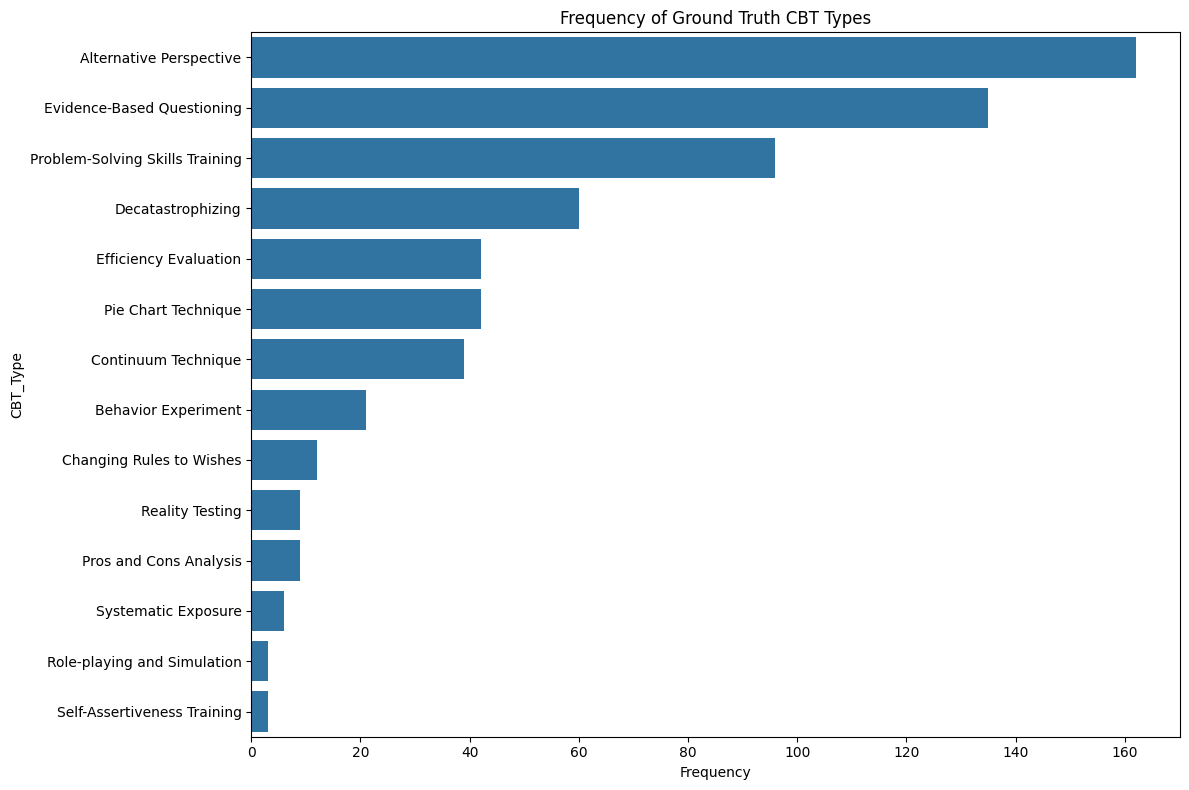

In [ ]:
# Extract and analyze different types of ground truth CBT
# First, split the comma-separated values
df['cbt_types'] = df['ground_truth_CBT'].str.split(',')

# Flatten and count all CBT types
all_cbt_types = []
for cbt_list in df['cbt_types']:
    if isinstance(cbt_list, list):
        all_cbt_types.extend([cbt.strip() for cbt in cbt_list])
    else:
        # Handle case where it might be a string or NaN
        if isinstance(cbt_list, str):
            all_cbt_types.append(cbt_list.strip())

# Count frequencies
cbt_counter = Counter(all_cbt_types)

print("\n=== Ground Truth CBT Frequency Analysis ===")
for cbt_type, count in cbt_counter.most_common():
    print(f"{cbt_type}: {count} ({count/len(all_cbt_types)*100:.2f}%)")

# Plot CBT type frequencies
plt.figure(figsize=(12, 8))
cbt_df = pd.DataFrame({'CBT_Type': list(cbt_counter.keys()),
                        'Frequency': list(cbt_counter.values())})
cbt_df = cbt_df.sort_values('Frequency', ascending=False)

# If there are many types, limit to top 15 for readability
if len(cbt_df) > 15:
    print("\nShowing top 15 CBT types in graph. See full list above.")
    cbt_df = cbt_df.head(15)

sns.barplot(x='Frequency', y='CBT_Type', data=cbt_df)
plt.title('Frequency of Ground Truth CBT Types')
plt.tight_layout()
plt.show()


=== Number of CBT Types per Entry ===
num_cbt_types
1    225
2    171
3     24


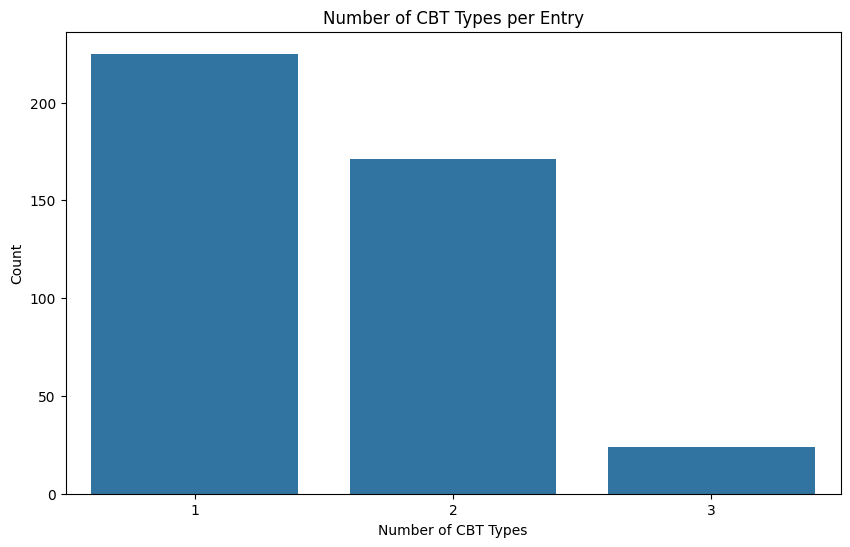

In [ ]:
# Count number of CBT types per entry
df['num_cbt_types'] = df['cbt_types'].apply(len)

print("\n=== Number of CBT Types per Entry ===")
print(df['num_cbt_types'].value_counts().sort_index().to_string())

# Plot number of CBT types per entry
plt.figure(figsize=(10, 6))
sns.countplot(x='num_cbt_types', data=df)
plt.title('Number of CBT Types per Entry')
plt.xlabel('Number of CBT Types')
plt.ylabel('Count')
plt.show()

In [ ]:

"""
Analyze the most common words in intake forms for each category of ground truth CBT, excluding stopwords.

Args:
    df (pandas.DataFrame): DataFrame containing the CBT data
"""
# Get NLTK's stopwords and combine with spaCy's for a comprehensive list
nltk_stop_words = set(stopwords.words('english'))
spacy_stop_words = nlp.Defaults.stop_words
stop_words = nltk_stop_words.union(spacy_stop_words)

# Create a dictionary to hold all intake forms for each CBT type
cbt_category_texts = {}

# Extract intake forms by CBT category
for _, row in df.iterrows():
    if isinstance(row['cbt_types'], list) and isinstance(row['intake_form'], str):
        for cbt_type in row['cbt_types']:
            cbt_type = cbt_type.strip()
            if cbt_type not in cbt_category_texts:
                cbt_category_texts[cbt_type] = []
            cbt_category_texts[cbt_type].append(row['intake_form'])

print("\n=== Top 5 Words in Intake Forms by CBT Category ===")

# For word cloud visualization
all_category_word_freqs = {}

# Process each CBT category
for cbt_type, texts in cbt_category_texts.items():
    # Process texts with spaCy for better lemmatization and filtering
    processed_texts = []
    for text in texts:
        if isinstance(text, str):
            doc = nlp(text.lower())
            # Keep only meaningful words: not stopwords, punctuation, or short words
            tokens = [token.lemma_ for token in doc
                      if not token.is_stop and not token.is_punct and len(token.text) > 1]
            processed_texts.append(' '.join(tokens))

    if processed_texts:
        # Use CountVectorizer to get word frequencies
        vectorizer = CountVectorizer(stop_words=list(stop_words), min_df=1)
        X = vectorizer.fit_transform(processed_texts)

        # Get word counts
        word_freq = [(word, X[:, idx].sum()) for word, idx in vectorizer.vocabulary_.items()]
        word_freq.sort(key=lambda x: x[1], reverse=True)

        # Store for word cloud
        category_word_dict = dict(word_freq)
        all_category_word_freqs[cbt_type] = category_word_dict

        # Print top 5 words for this category
        print(f"\n{cbt_type} (based on {len(texts)} intake forms):")
        for word, count in word_freq[:10]:
            print(f"  {word}: {count}")

        # Plot top words for each category
        plt.figure(figsize=(10, 4))
        word_df = pd.DataFrame(word_freq[:5] if len(word_freq) >= 5 else word_freq,
                              columns=['Word', 'Frequency'])

        sns.barplot(x='Frequency', y='Word', data=word_df)
        plt.title(f'Top Intake Form Words for "{cbt_type}"')
        plt.tight_layout()
        plt.savefig(f'intake_words_{cbt_type.replace(" ", "_").lower()}.png')
        plt.close()

# Generate combined word cloud for categories with enough data
try:
    from wordcloud import WordCloud

    for cbt_type, word_dict in all_category_word_freqs.items():
        if len(word_dict) >= 5:  # Only create word clouds with enough words
            # Generate word cloud
            wordcloud = WordCloud(width=800, height=400,
                                background_color='white',
                                max_words=50).generate_from_frequencies(word_dict)

            # Display the word cloud
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Intake Form Word Cloud: {cbt_type}')
            plt.tight_layout()
            plt.savefig(f'intake_wordcloud_{cbt_type.replace(" ", "_").lower()}.png')
            plt.close()

    print("\nGenerated word cloud visualizations for intake forms by CBT category")
except ImportError:
    print("WordCloud package not installed. Skipping word cloud visualization.")




=== Top 5 Words in Intake Forms by CBT Category ===

Alternative Perspective (based on 162 intake forms):
  feeling: 765
  problem: 588
  counseling: 489
  experience: 345
  seek: 345
  self: 339
  relationship: 324
  past: 321
  history: 318
  affect: 294

Continuum Technique (based on 39 intake forms):
  feeling: 168
  problem: 144
  counseling: 117
  experience: 99
  seek: 90
  affect: 81
  self: 78
  past: 75
  history: 75
  life: 72

Decatastrophizing (based on 60 intake forms):
  problem: 204
  feeling: 204
  counseling: 180
  relationship: 138
  experience: 132
  seek: 132
  past: 129
  history: 114
  life: 114
  daily: 108

Evidence-Based Questioning (based on 135 intake forms):
  feeling: 492
  problem: 450
  counseling: 396
  self: 303
  seek: 294
  experience: 282
  past: 273
  relationship: 273
  history: 270
  affect: 246

Pie Chart Technique (based on 42 intake forms):
  feeling: 156
  problem: 132
  counseling: 129
  seek: 102
  experience: 99
  past: 96
  negative: 90
